In [1]:
import numpy as np
from scipy.io import wavfile
import scipy.fftpack as fft

import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

## Utils

In [2]:
def plot_time_domain(signal, sample_rate, title='Time Domain'):
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, len(signal) / sample_rate, num=len(signal)), signal)

    plt.title(title)
    plt.grid(True)

In [3]:
audio_path = 'data/wav/03a01Fa.wav'

In [4]:
sample_rate, signal = wavfile.read(audio_path)

The raw signal in time domain

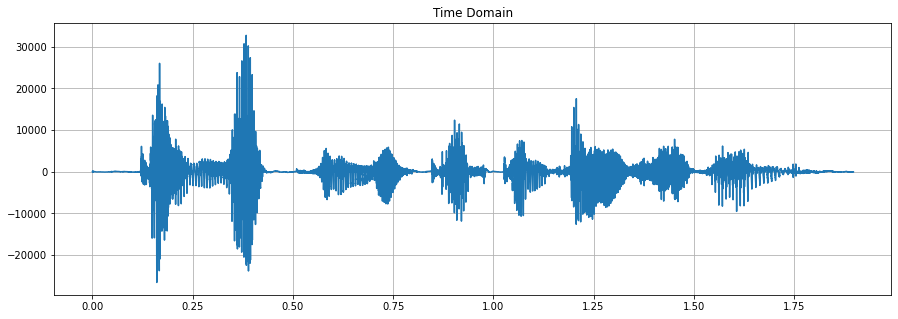

In [5]:
plot_time_domain(signal, sample_rate)

### Pre-Emphasis

Firstly, we filter the signal to amplify the high frequencies.

Pre-Emphasis increases the relative strength or amplitude of the high frequency coponents of the audio signal before modulation(modifying the audio).
Its used to improve signal quality at the output of a data transmission. Avoid numerical problems during the Fourier transform operation. And also improve Signal-to-Noise (SNR)

mathematicaly: y(t) = x(t) - ax(t - 1)
where a (alpha) is the filter coefficient and are 0.95 or 0.97.

Mean normalization can be used instead except for Fourier transform numerical issues which is not a problem to modern FFT implementations.

In [6]:
def emphasized_signal(signal, sample_rate, pre_emphasis=0.97):
    return np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

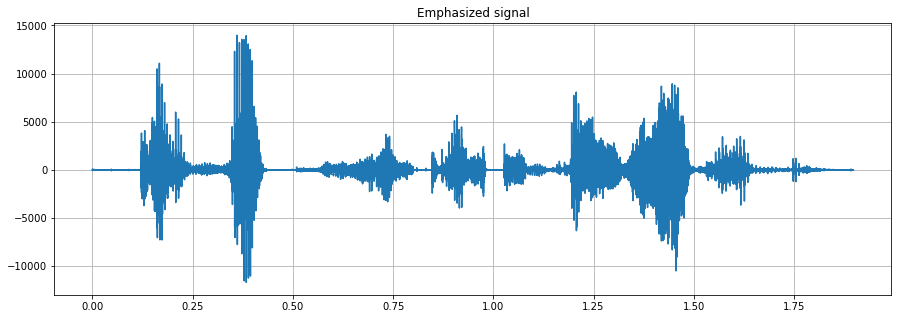

In [7]:
emphasized_signal_result = emphasized_signal(signal, sample_rate)
plot_time_domain(emphasized_signal_result, sample_rate
                 ,'Emphasized signal')

You can see a difference between the first graph and the emphasized_signal_result plot.

## Signal Framing

After pre-emphasis, we need to split the signal into short-time frames. Why?

An audio/signal frame contains amplitude (loudness) information at that particular point in time. To produce sound, tens of thousands of frames are played sequentially to produce frequencies.

Audio is a non-stationary process, so the FFT will produce distortions or lose frequency contours. So we can assume the audio is a stationary process for a short periods of time.
    Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Frame sizes in speech processing ranges between 20ms to 40ms with a 50% overlap between each frame.

a well know frame size is 25ms, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride=0.01

In [8]:
frame_size = 0.025
frame_stride = 0.01

In [9]:
# def frame_audio_1(emphasized_signal_result, frame_size=0.025, frame_stride=0.01):

#     # convert from samples to second
#     frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

#     signal_length = len(emphasized_signal_result)
#     frame_length = int(round(frame_length))
#     frame_step = int(round(frame_step))
#     frames_overlap = frame_length - frame_step

#     num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
#     rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)


#     # Make sure that we have at least 1 frame+
#     num_frames = np.abs(signal_length - frames_overlap) // np.abs(frame_length - frames_overlap)
#     rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)

#     if rest_samples != 0:
#         pad_signal_length = int(frame_step - rest_samples)
#         z = np.zeros((pad_signal_length))
#         pad_signal = np.append(emphasized_signal_result, z)
#         num_frames += 1
#     else:
#         pad_signal = emphasized_signal_result

#     # pad_signal_length = num_frames * frame_step + frame_length
#     # z = np.zeros((pad_signal_length - signal_length))
#     # pad_signal = np.append(emphasized_signal_result, z)

#     indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
#                 numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), 
#                            (frame_length, 1)).T

#     frames = pad_signal[indices.astype(numpy.int32, copy=False)]

#     return frames

Another alternative,

In [10]:
def stride_trick(audio, stride_len, stride_size):
    
    """
    Apply framing using the stride trick from numpy.
    """
    n_rows = ((audio.size - stride_len) // stride_size) + 1
    n = audio.strides[0]

    return np.lib.stride_tricks.as_strided(audio, shape=(n_rows, stride_len),
                                          strides=(stride_size*n , n))

In [11]:
def frame_audio(signal, frame_size=0.025, frame_stride=0.01):
    """
    Transform a signal into a series of overlapping frames.
    
    Its implemented in matlab to get a much faster framing.

    """
    assert frame_size > frame_stride, 'ParamError: Frame_size must be larger than frame_stride'
    
    # convert from samples to second
    frame_length, frame_size = frame_size * sample_rate, \
                                    frame_stride * sample_rate

    signal_length = len(signal)
    frames_overlap = frame_length - frame_size
    
    # compute number of frames and pad left sampes if needed to ensure all frames
    # have equal numbers without truncating the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(signal, np.array([0] * int(frame_size - rest_samples) * int(rest_samples != 0.)))
    
    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_size))
    
    return frames, frame_length
    

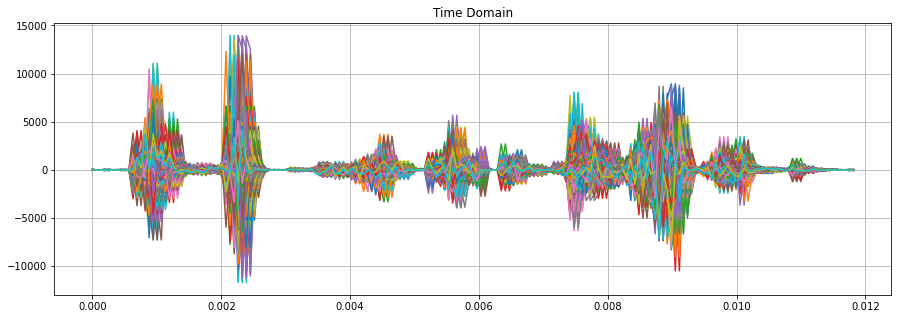

In [12]:
plot_time_domain(frame_audio(emphasized_signal_result)[0], sample_rate)

In [13]:
frames, frame_length = frame_audio(emphasized_signal_result)

In [14]:
print(f'Framed audio shape: {frames.shape} ')

Framed audio shape: (189, 400) 


In [15]:
print(f'First frame:\n\n{frames[1]}')


First frame:

[-1.456e+01  7.050e+00 -8.680e+00  3.110e+00  2.260e+00 -8.620e+00
 -1.830e+00  5.170e+00 -1.062e+01  1.100e-01  1.170e+00  2.600e-01
 -6.680e+00 -5.830e+00 -1.950e+00  5.050e+00 -4.740e+00 -1.830e+00
 -1.830e+00 -1.830e+00 -1.830e+00  1.170e+00  9.260e+00 -2.441e+01
 -2.100e+00  1.190e+01 -6.680e+00 -1.483e+01  8.780e+00  1.100e-01
 -7.830e+00 -1.000e-02 -3.950e+00 -5.010e+00  2.900e+00  2.050e+00
 -7.830e+00  1.990e+00  5.110e+00 -1.068e+01  5.000e-02  1.100e-01
 -3.830e+00  1.100e-01  7.170e+00 -3.560e+00 -3.620e+00 -3.680e+00
  2.260e+00 -1.620e+00 -3.620e+00  2.320e+00 -1.560e+00  3.440e+00
 -3.410e+00  4.530e+00  3.710e+00 -1.214e+01  5.300e-01 -8.410e+00
 -1.620e+00 -5.620e+00  1.126e+01  6.500e-01 -1.429e+01  2.320e+00
  3.440e+00  5.900e-01 -3.350e+00 -3.410e+00 -4.470e+00  1.440e+00
  7.530e+00 -4.200e+00  1.710e+00 -4.200e+00  5.710e+00 -3.080e+00
 -3.140e+00  1.180e+01 -6.810e+00 -5.990e+00 -1.140e+00 -1.140e+00
  3.860e+00 -5.990e+00  9.860e+00 -4.810e+00 -5.

In [16]:
print(f'Last frame:\n\n{frames[-1]}')


Last frame:

[-5.4400e+00  1.3500e+00  1.3500e+00  1.0350e+01  1.6200e+00 -5.3800e+00
  1.4100e+00 -5.9000e-01  8.3500e+00 -5.4400e+00  3.3500e+00  1.4100e+00
 -5.5900e+00  6.2000e+00 -3.6500e+00 -7.8000e+00  9.3000e-01 -1.0700e+00
  7.8700e+00  1.0080e+01 -6.5000e-01  3.2900e+00 -1.0650e+01  3.9900e+00
 -3.9200e+00 -8.0700e+00 -3.3400e+00 -2.4600e+00  7.4500e+00 -1.3400e+00
 -1.4000e+00  9.5400e+00  8.1000e-01  8.1000e-01  4.8100e+00 -1.5070e+01
 -5.5500e+00  4.2700e+00 -1.6100e+00 -1.6700e+00  9.2700e+00  6.5400e+00
 -1.2280e+01 -1.0670e+01 -2.0000e+00 -9.0600e+00 -2.3300e+00  1.8610e+01
 -3.8200e+00 -1.9400e+00  6.0000e+00  3.1800e+00 -8.7300e+00  4.0000e+00
 -1.8800e+00 -5.9400e+00  1.8800e+00 -2.0600e+00  5.8800e+00  9.0600e+00
 -1.6700e+00 -1.2730e+01 -2.1200e+00 -3.1800e+00 -2.7000e-01 -6.2700e+00
  1.0550e+01  7.8800e+00 -3.8800e+00  9.0000e+00  2.2700e+00 -6.6700e+00
 -3.8800e+00 -9.0000e+00 -6.2700e+00 -9.4500e+00  5.2800e+00  6.4600e+00
 -4.3300e+00  3.5500e+00  1.6700e+00 -

## Window

Convert audio from time domain to frequency domain. FFT assumes audio to be periodic an continues. By framing the signal we assured the audio to be periodic.

To make it continues we apply a window function on every frame to break the high frequency distortions. The window assures that both ends of the signal will end close to zero.

NB: We need to apply the window on the framed audio before we can perform FFT.

In [53]:
# to demonstrate the difference between hanning and hamming
frames_hanning = frames
frames_hamming = frames
demo_frames = frames

index = 90

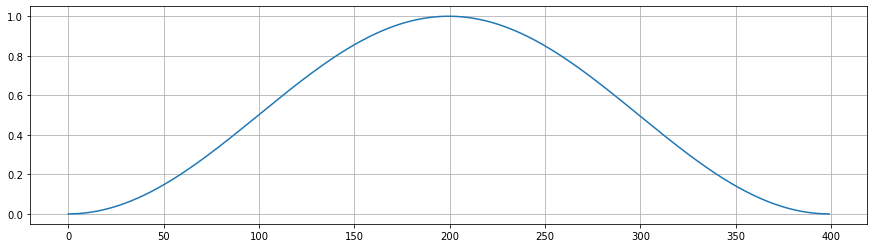

In [18]:
# for hanning

plt.figure(figsize=(15, 4))
plt.plot(np.hanning(frame_length))
plt.grid(True)

Hanning window touches zero at both ends, removing discontinuity.

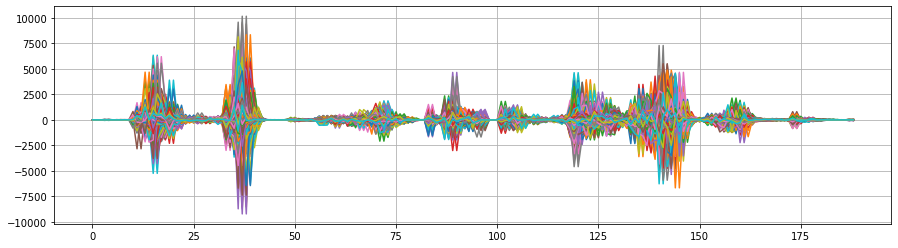

In [19]:
# for hanning

frames_hanning *= np.hanning(frame_length)

# explicit implementation
# frames_hanning *= 1 - np.cos((2 * np.pi * t) / frame_length - 1)

plt.figure(figsize=(15, 4))
plt.plot(frames_hanning)
plt.grid(True)

In [54]:

from scipy.signal import get_window



signal_win = frames_hanning * np.hanning(n_fft)

ValueError: operands could not be broadcast together with shapes (189,400) (512,) 

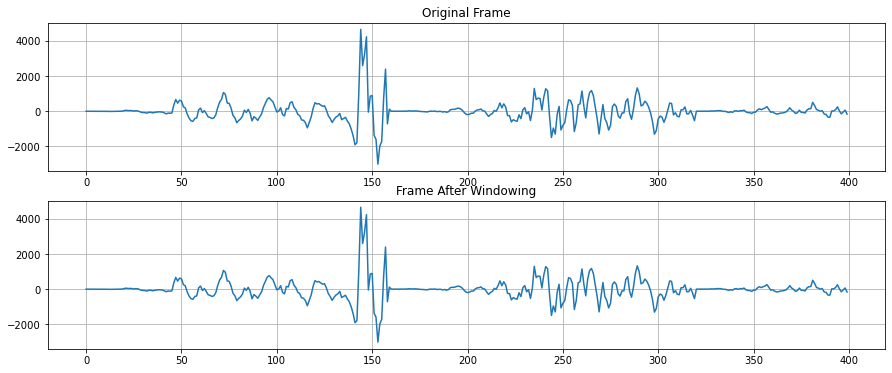

In [20]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(demo_frames[index])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(frames_hanning[index])
plt.title('Frame After Windowing')
plt.grid(True)

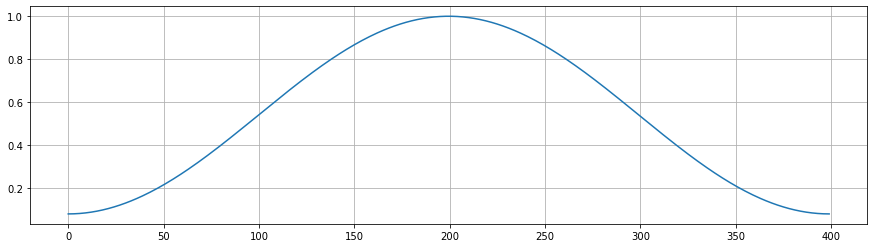

In [21]:
# for hamming

plt.figure(figsize=(15, 4))
plt.plot(np.hamming(frame_length))
plt.grid(True)

Hamming window stops just shy of zero, meaning that the signal still a a slight discontinuity(spectral leakage).


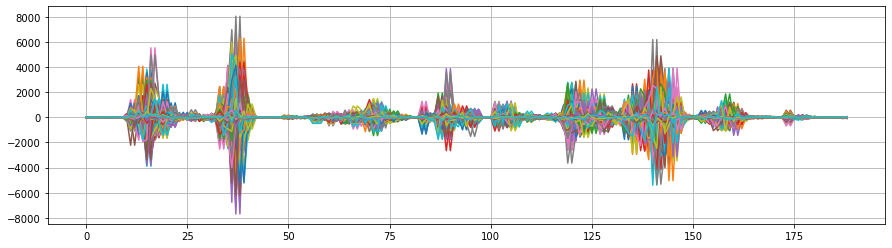

In [22]:
# for hamming

frames_hamming *= np.hamming(frame_length)

# explicit implementation
# frames_hamming *=  0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  

plt.figure(figsize=(15, 4))
plt.plot(frames_hamming)
plt.grid(True)

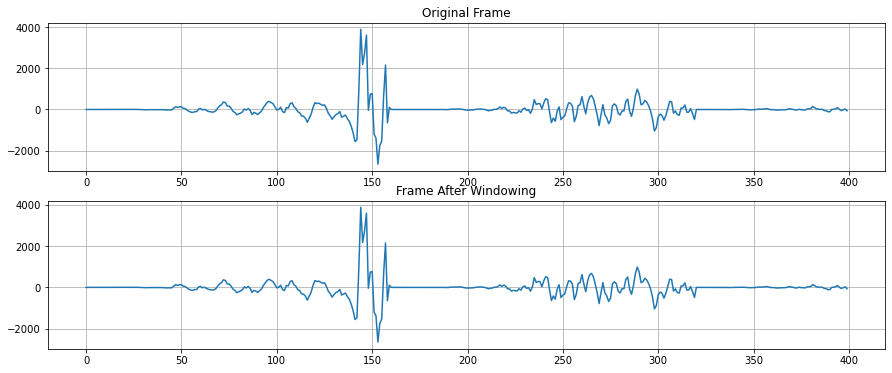

In [23]:

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(demo_frames[index])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(frames_hamming[index])
plt.title('Frame After Windowing')
plt.grid(True)

Between hamming an hanning, hamming windows does better job of cancelling the nearest side lobe but a poor job cancelling the rest.

In [24]:
# Now apply hanning window on frames
frames *= np.hanning(frame_length)

## Fourier-Transform and Power Spectrum

Now peform the N-point FFT on each frame to calculate the frequency spectrum which is called the Short-Time Fourier-Transform(STFT).
We'll only take the positive part of the spectrum(first half).

From the stft, N is typically the frame size which divides the frame signal into frame samples. Somes sizes are 256, 512, 1024 going. Frame sizes are  in the power of 2.




In [25]:
frames_winT = frames.T

n_fft = 512

signal_fft = np.empty((int(1 + n_fft // 2), frames_winT.shape[1]),
                      dtype=np.complex64, order='F')

for i in range(signal_fft.shape[1]):
    signal_fft[:, i] = fft.fft(frames_winT[:, i], axis=0)[:signal_fft.shape[0]]
    
signal_fft = signal_fft.T

In [26]:
signal_fft.shape

(189, 257)

In [27]:
# alternative,
# mag_frames = np.absolute(np.fft.rfft(frames, n_fft))  # Magnitude of the FFT
# pow_frames = ((1.0 / n_fft) * ((mag_frames) ** 2))  # Power Spectrum

In [28]:
# pow_frames.shape

In [29]:
# signal_fft.shape

In [30]:
# mag_frames.shape

#### calculate signal's power

In [31]:
signal_power = np.square(np.abs(signal_fft))
print(signal_power.shape)

(189, 257)


## Mel-spaced filterbank

Compute the Mel-space filter banks and pass the framed audio through them. This will give us information about the power in each frequency band.

The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. 

Mel filter banks helps to get the different frequency from the normal fft and convert them the normal frequency in hertz. MEL-spaced filterbanks is the spacing between the filters grows exponentially with frequency.

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0.

In [32]:
f_min = 0 # frequency minimum
f_max = sample_rate / 2  # frequency maximum
mel_filter_num = 12 # num_ceps

print(f'Minimum freq.: {f_min}')
print(f'Maximum freq.: {f_max}')

Minimum freq.: 0
Maximum freq.: 8000.0


#### Compute filter points

1. First convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies.

2. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.

In [33]:
 # Convert Hz to Mel
def freqToMel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

# inverse, convert Mel to Hz
def melToFreq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [34]:
def getFilterPoints(fmin, fmax, mel_filter_num, fft_size, sample_rate=sample_rate):
    
    fmin_mel = freqToMel(fmin)
    fmax_mel = freqToMel(fmax)
    
    print(f'MEL min: {fmin_mel}')
    print(f'MEL min: {fmax_mel}')
    
    # Equally spaced in Mel scale
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = melToFreq(mels)
    
    return np.floor((fft_size + 1) / sample_rate * freqs).astype(int), freqs

In [35]:
filter_points, mel_freqs = getFilterPoints(f_min, f_max, mel_filter_num,
                                          n_fft, sample_rate)
filter_points

MEL min: 0.0
MEL min: 2840.023046708319


array([  0,   4,  10,  17,  26,  36,  49,  64,  83, 106, 133, 166, 207,
       256])

#### Construct the filterbank

In [36]:
def getFilters(filter_points, fft_size):
    
    filters = np.zeros((len(filter_points)-2, int(fft_size/2+1)))
    
    for i in range(len(filter_points)-2):
        filters[i, filter_points[i] : filter_points [i + 1]] = \
                    np.linspace(0, 1, filter_points[i + 1] - filter_points[i])
        filters[i, filter_points[i + 1]: filter_points [i + 2]] = \
                    np.linspace(1, 0, filter_points[i + 2] - filter_points[i + 1])

    return filters
        
        
    

Text(0.5, 1.0, 'Mel freq.')

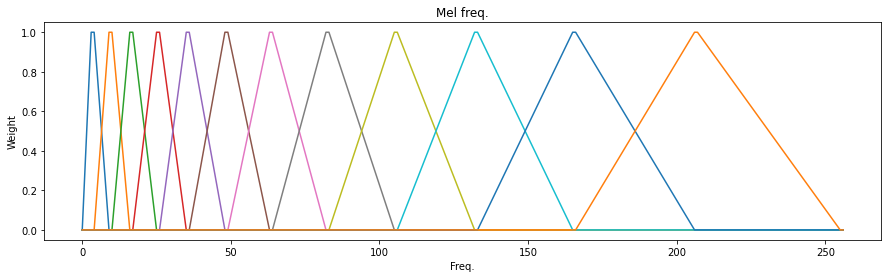

In [37]:
filters = getFilters(filter_points, n_fft)

plt.figure(figsize=(15, 4))

for i in range(filters.shape[0]):
    plt.plot(filters[i])
plt.ylabel('Weight')
plt.xlabel('Freq.')
plt.title('Mel freq.')

Next divide the triangular MEL weights by the width of the MEL band(area normalization). If the filters are not normalized, the noise will increase with frequency because of the filter width.

Weight is like a filter sound. If weight is equal to 1 , then dont touch the signal. When freq is high, we spread the distance to match the original spectrogram distance. Lower end frequency means, the frequency is muted.

In [38]:
# taken from librosa lib.

enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]  # mel filter shape, its in 2d

Text(0.5, 1.0, 'Normalized Mel freq.')

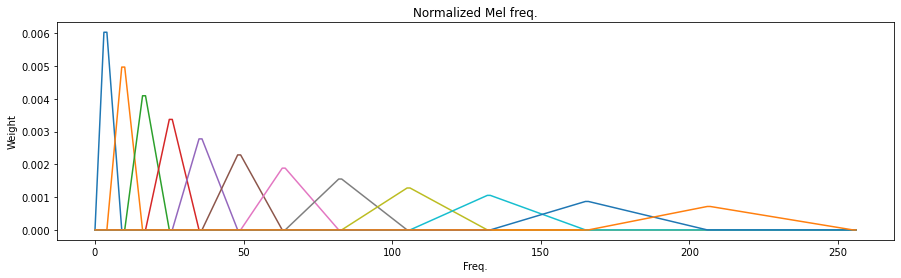

In [39]:
plt.figure(figsize=(15, 4))
for i in range(filters.shape[0]):
    plt.plot(filters[i])


plt.ylabel('Weight')
plt.xlabel('Freq.')
plt.title('Normalized Mel freq.')

In [40]:
# filter the signal
signal_filtered = np.dot(filters, signal_power.T)

# mel scale/mel spectrogram
signal_log = 20.0 * np.log10(signal_filtered) # since we perceive audios in decibels

signal_log.shape

(12, 189)

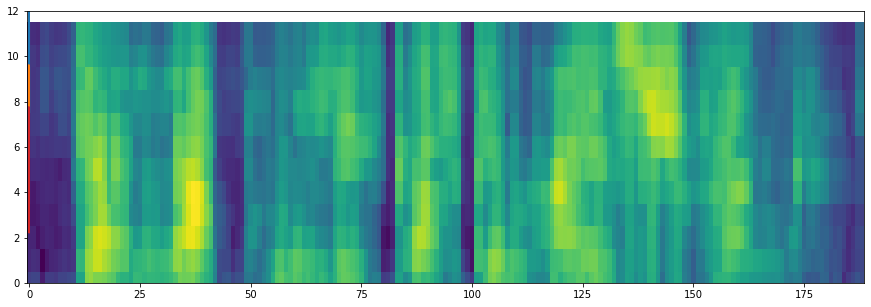

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(signal_log) / sample_rate, num=len(signal_log)), signal_log)
plt.ylim(0,signal_log.shape[0])
plt.imshow(signal_log, aspect='auto', origin='lower')

## Generate the cepstral Coefficiencts

It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. 

Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It'll extract the high frequency and low frequency changes in the signal.

In [42]:
def dct_vanilla(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num, filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)
    
    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
        
    return basis

In [43]:
dct_filter_num = 40 

dct_filters = dct_vanilla(dct_filter_num, mel_filter_num)

cepstral_coefficients = np.dot(dct_filters, signal_log)

cepstral_coefficients.shape

(40, 189)

Review the Cepstral Coefficients

In [44]:
cepstral_coefficients[:, 0]

array([ 8.41919114e+01, -1.19386455e+01,  8.01467443e+00,  1.70947789e+01,
        2.13660130e+00,  3.78869508e+00,  1.40362412e-01,  9.64145405e-01,
        3.21717876e+00,  2.80173855e+00,  5.19053185e-01,  2.30465792e+00,
       -1.44531324e-13, -2.30465792e+00, -5.19053185e-01, -2.80173855e+00,
       -3.21717876e+00, -9.64145405e-01, -1.40362412e-01, -3.78869508e+00,
       -2.13660130e+00, -1.70947789e+01, -8.01467443e+00,  1.19386455e+01,
       -1.19065343e+02,  1.19386455e+01, -8.01467443e+00, -1.70947789e+01,
       -2.13660130e+00, -3.78869508e+00, -1.40362412e-01, -9.64145405e-01,
       -3.21717876e+00, -2.80173855e+00, -5.19053185e-01, -2.30465792e+00,
        6.78197820e-13,  2.30465792e+00,  5.19053185e-01,  2.80173855e+00])

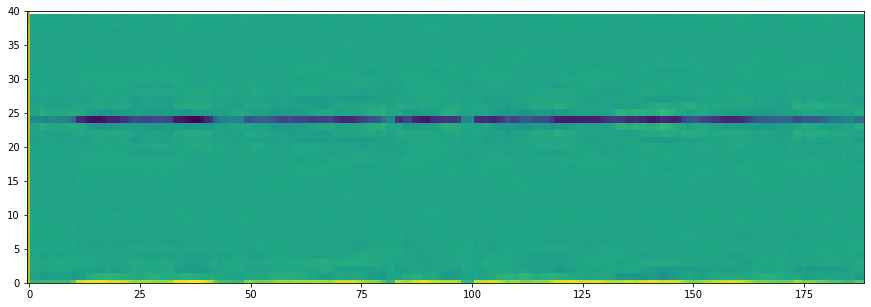

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(cepstral_coefficients) / sample_rate, num=len(cepstral_coefficients)), cepstral_coefficients)
plt.ylim(0,cepstral_coefficients.shape[0])
plt.imshow(cepstral_coefficients, aspect='auto', origin='lower')

## Mean Normalization

Its used to balance the spectrum and improve the Signal-to-Noise(SNR).

In [46]:
# for mel scale
signal_log -= (np.mean(signal_log, axis=0) + 1e-8)

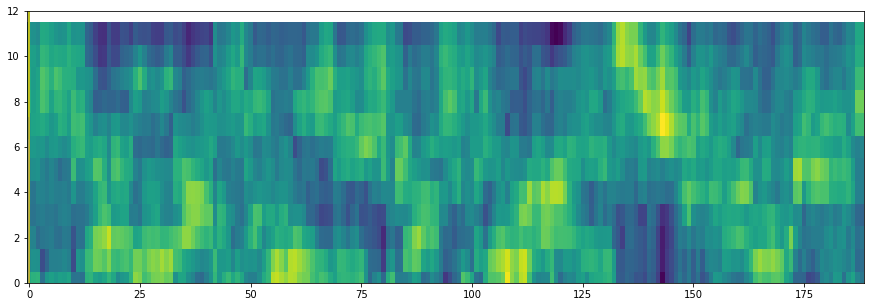

In [47]:
# display spectrogram of the signal
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(signal_log) / sample_rate, num=len(signal_log)), signal_log)
plt.ylim(0,signal_log.shape[0])
plt.imshow(signal_log, aspect='auto', origin='lower')

In [48]:
dct_filter_num = 40 

dct_filters = dct_vanilla(dct_filter_num, mel_filter_num)

cepstral_coefficients = np.dot(dct_filters, signal_log)

cepstral_coefficients.shape

(40, 189)

In [49]:
cepstral_coefficients -= (np.mean(cepstral_coefficients, axis=0) + 1e-8)

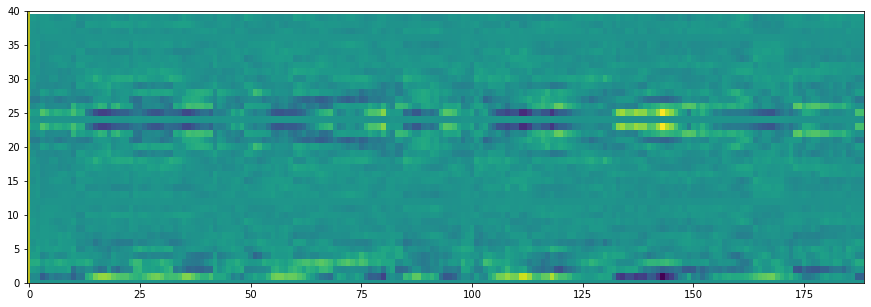

In [50]:
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(cepstral_coefficients) / sample_rate, num=len(cepstral_coefficients)), cepstral_coefficients)
plt.ylim(0,cepstral_coefficients.shape[0])
plt.imshow(cepstral_coefficients, aspect='auto', origin='lower')